### Установка пакетов

Начнем с установки необходимых пакетов python. Ничего необычного не понадобится - numpy, cv2, matplotlib

In [138]:
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib

Теперь можно импортировать

In [139]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from  random import randint
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

Функция для печать нескольких изображений

In [140]:
def print_images(images: list, color=None, matches:list=[]) -> None:
    
    images = [image.copy() for image in images]
    num_images = len(images)
    
    # Определяем количество столбцов и строк для сетки
    num_cols = 2 if num_images > 1 else 1
    num_rows = (num_images + 1) // 2  # Округляем вверх, если нечетное

    # Создаем фигуру и массив осей
    f, axarr = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axarr = axarr.ravel()  # Преобразуем оси в одномерный массив для удобства

    # Проходим по изображениям и отображаем их
    for i in range(num_images):

        if matches:
            pts = [(int(x), int(y)) for x, y in matches[i]]
            for pt in pts:
                cv2.circle(images[i], pt, 10, color, 2)
        
        axarr[i].imshow(images[i], cmap=color)
        axarr[i].axis("off")


    # Удаляем лишние оси, если количество изображений нечетное
    for i in range(num_images, len(axarr)):
        axarr[i].axis("off")
    
    plt.show()

    return None


Печать ключевых сматченных точек на изображении

### Инициализация SLAM с использованием OpenCV (30 баллов)

Итак, мы снова находимся в сгенерированном мире c первой лекции. У нас был автомобиль, на котором были установлены сенсоры, выдающие нам карту глубин вместе с картинкой, а так же трансформацию (позу) в каждый момент времени. Теперь перейдем к более реальной ситуации: на нашей машине установлена только камера и ничего более (очень часто решается именно такая задача). Будем восстанавливать позу и глубины точек при помощи знаний, полученных на лекции (восстановление превой позы иногда называют инициализацией). Начнем с восстановления позы

Вам даны два изображения, вращение и перемещение между которыми мы хотим определить

In [141]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

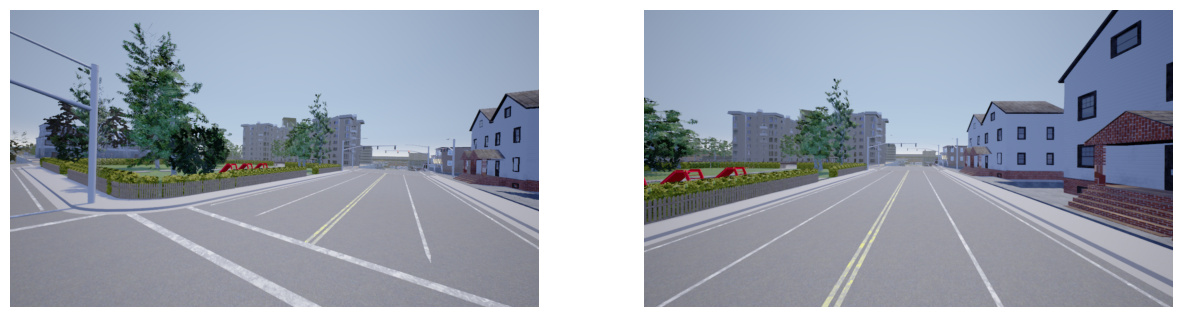

In [142]:
image1 = load_image("image1.png")
image2 = load_image("image2.png")
print_images([image1, image2])

Как мы узнали на лекции, первое, что нужно сделать для восстановления позы - найти особые точки (фичи) на обоих изображениях и соответствие между ними (сматчить). На второй лекции вы уже научились это делать, поэтому не будем сильно заострять на этом внимание: найдите фичи и матчи любым способом, который вам понравился ([здесь](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) можете найти пример с SIFT фичами)

Найдём лучшие фитчи на двух изображения

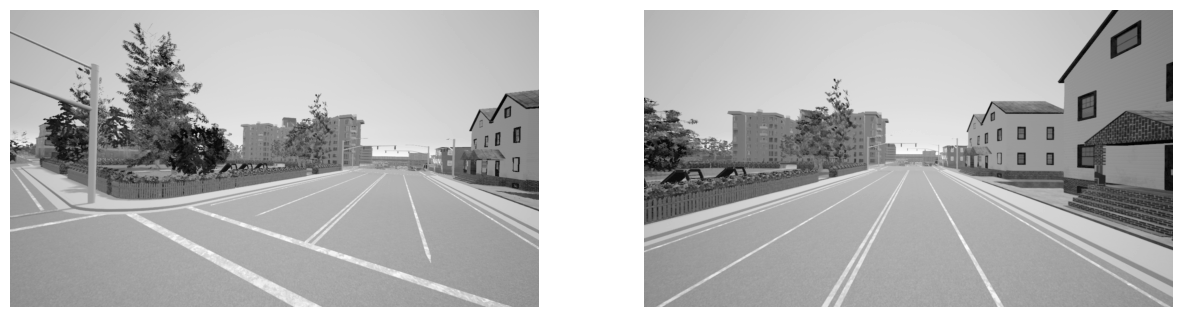

In [143]:
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
print_images([gray_image1, gray_image2], color="gray")

Инициализируется SIFT и определяются ключевые точки и их дескрипторы

In [144]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(gray_image1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(gray_image2, None)

С помощью FLANN матчера определяем "истинные" ключевые точки

In [145]:
# Создаем объект FlannBasedMatcher для поиска ближайших соседей между дескрипторами двух изображений
flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
# Выполняем сопоставление с использованием k-NN (2 ближайших соседа для каждого дескриптора)
matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.4*n.distance:
        pts2.append(keypoints_2[m.trainIdx].pt)
        pts1.append(keypoints_1[m.queryIdx].pt)

print(f"Number of key point on first image:{len(pts1)} and second image:{len(pts2)}")

Number of key point on first image:26 and second image:26


Визуализация "истинных" ключевых точек

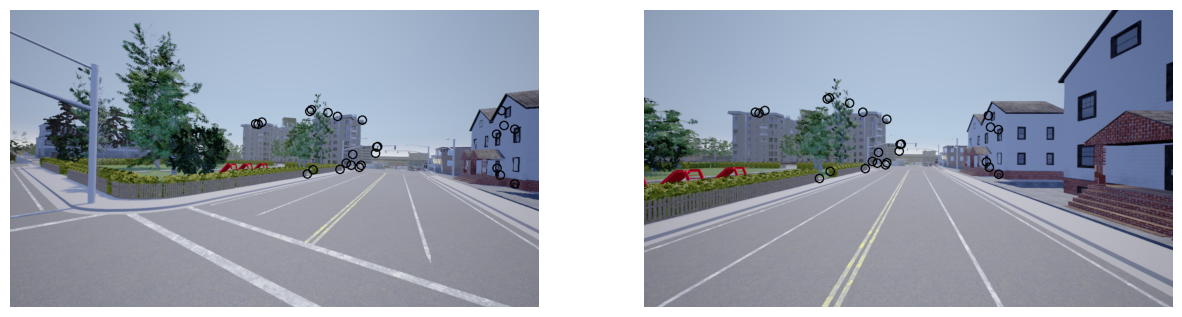

In [146]:
print_images([image1, image2], matches=[pts1, pts2])

In [147]:
# Создайте детектер/матчер, найдите фичи, сматчите их, выделите лучшие
# В итоге мы хотим получить
pts1 = np.array(pts1) # Numpy матрица Nx2 - координаты фич на левом изображении
pts2 = np.array(pts2) # Numpy матрица Nx2 - координаты фич на правом изображении
print(f"размерность первого набора точек:{pts1.shape} и второго:{pts2.shape}")

размерность первого набора точек:(26, 2) и второго:(26, 2)


Визуализируем наши матчи

In [148]:
def draw_matches(image_a: np.ndarray, image_b: np.ndarray, keypoints_a: np.ndarray, keypoints_b: np.ndarray):
    # initialize the output visualization image
    height_a, width_a = image_a.shape[:2]
    height_b, width_b = image_b.shape[:2]

    vis = np.zeros((max(height_a, height_b), width_a + width_b, 3), dtype="uint8")
    vis[0:height_a, 0:width_a] = image_a
    vis[0:height_b, width_a:] = image_b

    # loop over the matches
    for keypoint_a, keypoint_b in zip(keypoints_a, keypoints_b):
        # draw the match
        point_a = (int(keypoint_a[0]), int(keypoint_a[1]))
        point_b = (
            int(keypoint_b[0]) + width_a,
            int(keypoint_b[1]),
        )
        cv2.line(vis,
                 point_a,
                 point_b,
                 (randint(0, 255), randint(0, 255), randint(0, 255)), 1)

    # return the visualization
    return vis

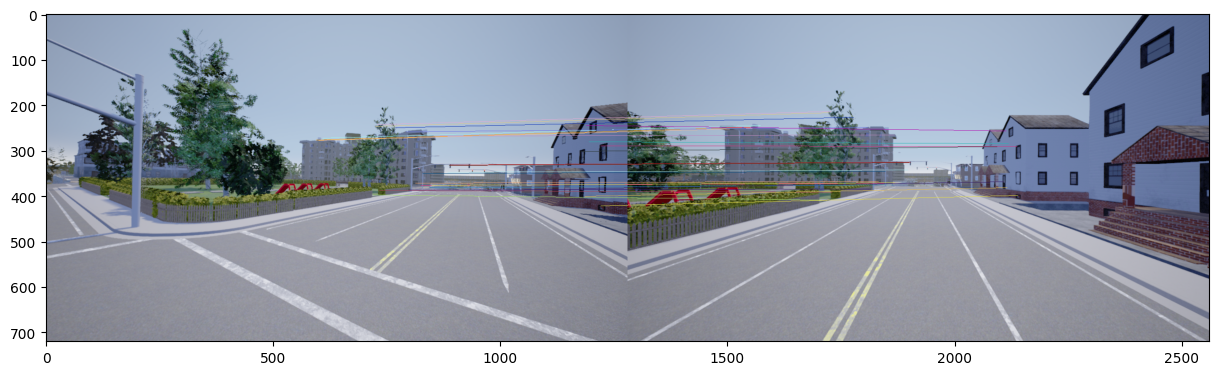

(<matplotlib.image.AxesImage at 0x1bba4d49ca0>, None)

In [149]:
img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Итак, у нас есть матчи. Начнем с простого - воспользуемся встроенной функцией в OpenCV для определения существенной матрицы. Смотрите референс [здесь](https://amroamroamro.github.io/mexopencv/matlab/cv.findEssentialMat.html). Вам нужно правильно определить матрицу камеры и передать точки с левого и правого изображения.

Аргументы функции cv2.findEssentialMat(pts1, pts2)
1. points1 Cell array of N (N>=5) 2D points from the first image, or numeric array Nx2/Nx1x2/1xNx2. The point coordinates should be floating-point (single or double precision).
2. points2 Cell array or numeric array of the second image points of the same size and format as points1.

In [150]:
fx = 448.1551643293023
fy = 448.1551643293023
px = 640.0
py = 360.0

K = np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]]) # TODO: заполните матрицу камеры
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=0.1) # TODO: получите существенную матрицу

In [151]:
print(f"Модель камеры:\n{K}\n")
print(f"Существенная матрица:\n{E}\n")
print(f"Маска существенной матрицы:\n{mask.T}\n")

Модель камеры:
[[448.15516433   0.         640.        ]
 [  0.         448.15516433 360.        ]
 [  0.           0.           1.        ]]

Существенная матрица:
[[ 0.01838853 -0.70243435  0.00496776]
 [ 0.63845292  0.01394556 -0.3035668 ]
 [-0.00296104 -0.07897027  0.00294719]]

Маска существенной матрицы:
[[1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0]]



Отлично, у нас есть существенная матрица E, а также некторая маска mask. Это маска показывает, какие из матчей у нас соответствуют полученной матрице (inliers), а какие нет (outliers).

In [152]:
pts1_inliers = pts1[mask.ravel() == 1] # Numpy матрица Mx2 - координаты инлайеров на левом изображении
pts2_inliers = pts2[mask.ravel() == 1] # Numpy матрица Mx2 - координаты инлайеров на правом изображении

Визуализиреум инлайеры и посмотрим, какой процент точек оказался инлайерами. Чем процент больше, тем лучше был наш матчер. Нормально, если он будет около 50%.

Процент инлайеров: 53.84615384615385%


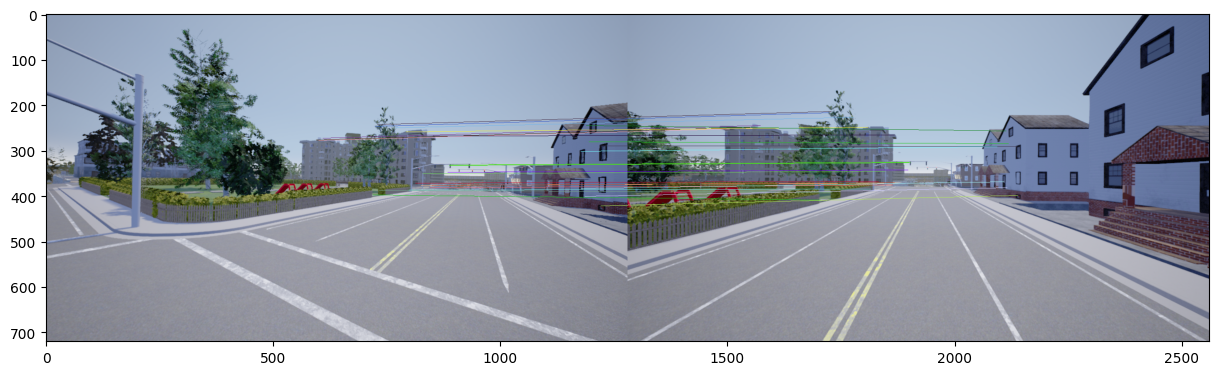

(<matplotlib.image.AxesImage at 0x1bba5350970>, None)

In [153]:
print(f"Процент инлайеров: {pts1_inliers.shape[0] / pts1.shape[0] * 100}%")

img3 = draw_matches(image1, image2, pts1, pts2)
plt.imshow(img3),plt.show()

Если визуально корреспонденсы между изображениями выглядят адекватно, то самое время восстанавливать позу из существенной матрицы. Сейчас воспользуемся для этого внутренней функцией OpenCV - recoverPose. Не забудьте использовать для это только инлайеры!

In [154]:
numOfInliers, R_opencv, t_opencv, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K) # Воостановите позу из E с помощью recoverPose

Отлично, у нас есть оцененные R и t. Самое время сравнить его с ground truth (gt), который нам был дан в первом задании. Есть один нюанс: на лекции мы узнали, что из алгоритмов такого рода нельзя восстановить скейл сцены, поэтому перед сравнением t_gt нужно нормализовать.

In [155]:
R_gt = np.array([[8.50318515e-01, 2.07742095e-02, -5.25858208e-01],
              [-2.47312245e-02, 9.99694013e-01, -4.97406376e-04],
              [5.25686969e-01, 1.34280713e-02, 8.50572100e-01]])
t_gt = np.array([[6.51715996e-01, 6.20712517e-03, -6.44666629e+00]]).transpose()
scale = np.linalg.norm(t_gt)
t_gt /= scale

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_opencv) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_opencv) / np.linalg.norm(t_gt) * 100}%")

Ошибка в матрице вращения: 0.26680214887137454%
Ошибка в перемещении: 1.411181627151348%


Ошибиться на 1% во вращении и на 3% в перемещении - это нормально, хороший результат.

И последний этап с использованием готовых функций: восстановим глубины фич. Для этого нужно воспользоваться функцией triangulatePoints из библиотеки OpenCV. У нее чуть более хитрые входные данные, составим их поэтапно. Подумайте над тем, какую именно позу мы нашли (R_opencv, t_opencv), и какие позы у первого и второго изображения.

In [156]:
projection_matrix_1 = K @ np.eye(3,4) # проективная матрица для первого изображения. Напоминаем, что проективная матрица это
                          # CameraMatrix @ np.eye(3, 4) @ PoseMatrix4x4
projection_matrix_2 = K @ np.hstack((R_gt,t_gt)) # проективная матрица для второго изображения. Напоминаем, что проективная матрица это
                          # CameraMatrix @ np.eye(3, 4) @ PoseMatrix4x4
points_3d_hom = cv2.triangulatePoints(projection_matrix_1, projection_matrix_2, pts1_inliers.T, pts2_inliers.T) # триангулируйте точки с помощью triangulatePoints. Это будут 3D точки в однородных координатах
points_3d = points_3d_hom/points_3d_hom[3] # превратите 3D из однородных координат в обычные
depth_opencv = points_3d[2] # получите глубины из данных 3D точек. Это делжен быть вектор длиной M (количество инлайеров).

Самое время загрузить глубины, которые были даны в первом ДЗ и сравнить с полученными. Опять же, не забудьте, что глубины точек метрические, а значит зависят от скейла. Мы уже зафиксировали скейл для gt, поэтому воспользуемся им.

In [157]:
# Загрузим gt глубины, нормируем их
depth_gt_full = np.load("depth1.npy") * 1000 / scale
# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

# Посчитаем среднюю ошибку. Не будем учитывать слишком далекие точки
errors = []
for i, d_gt in enumerate(depth_gt):
    if d_gt < 100 / scale:
        print(d_gt, depth_opencv[i])
        errors.append(abs(d_gt - depth_opencv[i]) / max(d_gt, depth_opencv[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}%")

5.193572 4.674322746074578
13.461395 13.146099738388555
7.3215666 7.219818004041946
12.438972 10.570192817912915
12.673995 11.247714954662396
13.639385 14.412083069958282
6.862449 7.1277199816064
4.0980816 4.0791307957299505
3.988182 4.000249686997167
3.462749 3.4520214169674013
Средняя ошибка в определении глубин: 5.016407245337378%


Отлично, ошибиться на 10% в определении глубин - это нормально, на это влияет много факторов.

Итак мы продедади полную инициализацию SLAM - нашли матчи, посчитали существенную матрицу, восстановили позу и глубины. На этом задача заверщается и далее предлалагается продлелать те же вещи, но написать все алгоритмы самостоятельно

### Инициализация SLAM с использованием самописных методов (20 баллов)

Начнем опять с восстановления существенной матрицы. Не забудьте, что на вход мы подаем изначальные точки, pts1 и pts2

In [158]:
def normalize_points(points):
    """
    Нормализует точки для повышения численной устойчивости,
    используя центрирование и масштабирование.
    """
    centroid = np.mean(points, axis=0)
    shifted_points = points - centroid
    avg_dist = np.mean(np.sqrt(np.sum(shifted_points**2, axis=1)))
    scale = np.sqrt(2) / avg_dist
    
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0, 0, 1]])
    
    normalized_points = (T @ np.hstack((points, np.ones((points.shape[0], 1)))).T).T
    return normalized_points[:, :2], T

In [159]:
def findEssentialMatrix8pt(pts1_8pt, pts2_8pt, K):
    # В данный функции реализуйте 8 points алгоритм для определения существенной матрицы
    # В качестве сингулярных чисел используйте сразу [1, 1, 0]

    # Нормализация точек
    pts1_h = np.hstack((pts1_8pt, np.ones((8, 1)))).T
    pts2_h = np.hstack((pts2_8pt, np.ones((8, 1)))).T

    pts1_norm = (np.linalg.inv(K) @ pts1_h).T
    pts2_norm = (np.linalg.inv(K) @ pts2_h).T

    # Инициализация матрицы A
    A = np.zeros((8,9))
    for i in range(8):
        x1, y1, _ = pts1_norm[i]
        x2, y2, _ = pts2_norm[i]

        # Формируем матрицу A
        # A[i] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]
        # pt2.T * E * pt1 <- MATLAB
        # e33 + x1*(e31 + e11*x2 + e21*y2) + y1*(e32 + e12*x2 + e22*y2) + e13*x2 + e23*y2 <- MATLAB syms
        # e11(x2*x1) + e12(x2*y1) + e13(x2) + e21(y2x1) + e22(y2y1) + e23(y2) + e31(x1) + e32(y1) + e33(1)
        A[i] = [x1*x2, y1*x2, x2, x1*y2, y1*y2, y2, x1, y1, 1]

    # Используем SVD для нахождения фундаментальной матрицы (последняя строка V^T)
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    U, D, Vt = np.linalg.svd(F)
    # D[-1] = 0 # [1,1,0]
    E = U @ np.diag([1, 1, 0]) @ Vt
    # E = U @ np.diag(D) @ Vt

    return E

In [160]:
def findEssentialMatrixRansac(pts1, pts2,
                              K,                              
                              samples=2000, threshold=0.1, 
                              seed=42):
    """
    RANSAC алгоритм для надежной оценки существенной матрицы
    Args:
        pts1: (Nx2) точки на первом изображении
        pts2: (Nx2) точки на втором изображении
        K: (3x3) внутренняя матрица камеры
        samples: количество итераций RANSAC
        threshold: порог для более глубокой классификации
    Returns:
        best_E: (3x3) лучшая существенная матрица
        best_mask: (Nx1) boolean mask indicating inliers
    """
    assert pts1.shape==pts2.shape, "Размерности массивов точек должны быть равны"

    best_E = None 
    best_mask = None
    # чем больше инлайеров тем лучше существенная матрица
    max_inliers = 0

    N = pts1.shape[0] # размерность массива точек
    # фиксирование случайного сида
    np.random.seed(seed)

    # нормализация точек
    # 1. формирование гомогенных координат
    pts1_h = np.hstack((pts1, np.ones((N, 1))))
    pts2_h = np.hstack((pts2, np.ones((N, 1))))

    # нормализация веторов
    pts1_norm = (np.linalg.inv(K) @ pts1_h.T).T
    pts2_norm = (np.linalg.inv(K) @ pts2_h.T).T

    for _ in range(samples):
        mask_inliers = []
        num_inliers = 0
        # Выбираем случайные индексы и соответствующие координаты 
        indices = np.random.choice(N, size=8, replace=False)
        pts1_8pts = pts1[indices]
        pts2_8pts = pts2[indices]

        # Определяем существенную матрицу с помощью 8-ми точечного алгоритма
        E = findEssentialMatrix8pt(pts1_8pts, pts2_8pts, K)

        # Проверяем каждую точку на решению эпиполярного ограничения
        for i in range(N):
            x1 = pts1_norm[i].reshape(3,1)
            x2 = pts2_norm[i].reshape(3,1)
            
            err = abs(x2.T @ E @ x1)

            if err < threshold:
                mask_inliers.append(True)
                num_inliers += 1
            else:
                mask_inliers.append(False)

        # фильтр лучшей матрицы
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_E = E
            best_mask = np.array(mask_inliers, dtype=bool)

    return best_E, best_mask


Воспользуйтесь новой функцией, определите существенную матрицу и вновь определите инлайеры

In [161]:
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=0.01)
E_est, mask_est = findEssentialMatrixRansac(pts1, pts2, K, samples=1000, threshold=0.01)
pts1_inliers = pts1[mask_est] # Numpy матрица Mx2 - координаты инлайеров на левом изображении
pts2_inliers = pts2[mask_est] # Numpy матрица Mx2 - координаты инлайеров на правом изображении

Сравните визульно E (определена с помощью OpenCV) и E_est (определена вручную). Если есть небольшие отличия - это не страшно, иметь смысл будет только восстановленная поза.

In [162]:
print("OpenCV существенная матрица")
print(E)
print("Custom существенная матрица")
print(E_est)

OpenCV существенная матрица
[[ 0.00970131  0.03573515  0.01323112]
 [-0.5169863  -0.03195224 -0.48102979]
 [-0.06610783  0.70275578  0.02307506]]
Custom существенная матрица
[[-2.52954914e-02  9.92394777e-01 -2.61029074e-04]
 [-9.06622725e-01 -2.29872669e-02  4.21315571e-01]
 [-2.98591166e-03  1.20431574e-01 -7.05986342e-05]]


Далее напишите кастомную функцию для восстановления позы из существенной матрицы

In [163]:
def recoverPose(E, pts1, pts2, K):
    """
    Восстанавливает позу камеры из существенной матрицы E
    
    Args:
        E (ndarray): Существенная матрица 3x3
        pts1 (ndarray): Точки на первом изображении (Nx2)
        pts2 (ndarray): Точки на втором изображении (Nx2)
        K (ndarray): Калибровочная матрица камеры 3x3
    
    Returns:
        R (ndarray): Матрица поворота 3x3
        t (ndarray): Вектор переноса 3x1
    """
    # SVD разложение матрицы E
    U, _, Vt = np.linalg.svd(E)
    
    # Проверка определителя для обеспечения правой системы координат
    if np.linalg.det(U) < 0:
        U = -U
    if np.linalg.det(Vt) < 0:
        Vt = -Vt
    
    # Матрица W для получения R
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    # 4 возможные гипотезы для R и t
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    t1 = U[:, 2].reshape(3, 1)
    t2 = -t1
    
    poses = [(R1, t1), (R1, t2), (R2, t1), (R2, t2)]
    
    # Конвертация точек в однородные координаты и переход в лучи
    pts1_norm = np.linalg.inv(K) @ np.vstack((pts1.T, np.ones(pts1.shape[0])))
    pts2_norm = np.linalg.inv(K) @ np.vstack((pts2.T, np.ones(pts2.shape[0])))
    
    max_points_front = -1
    best_pose = None
    
    # Проверка каждой гипотезы
    for R, t in poses:
        points_front = 0
        
        # Триангуляция точек для текущей гипотезы
        points_4d = triangulatePoints(pts1_norm[:2].T, pts2_norm[:2].T, R, t, np.eye(3))
        points_3d = points_4d[:, :3] / points_4d[:, 3:]
        
        # Проверка глубины для обеих камер
        depths1 = points_3d[:, 2]
        depths2 = (R @ points_3d.T + t).T[:, 2]
        
        # Подсчет точек перед обеими камерами
        points_front = np.sum((depths1 > 1) & (depths2 > 1))
        
        if points_front > max_points_front:
            max_points_front = points_front
            best_pose = (R, t)
    
    return best_pose[0], best_pose[1]

Воспользуйтесь новой функцией, восстановите позу и сравните ее с gt. Больше или меньше ошибка, по сравнении с методом из OpenCV?

In [164]:
R_custom, t_custom = recoverPose(E_est, pts1_inliers, pts2_inliers, K)

print(f"Ошибка в матрице вращения: {np.linalg.norm(R_gt - R_custom) / np.linalg.norm(R_gt) * 100}%")
print(f"Ошибка в перемещении: {np.linalg.norm(t_gt - t_custom) / np.linalg.norm(t_gt) * 100}%")

Ошибка в матрице вращения: 0.16984684187627475%
Ошибка в перемещении: 2.003785184842075%


In [165]:
def triangulatePoints(pts1, pts2, R, t, K):
    # Реализуйте триангуляцию, аналогичную OpenCV.
    # Не надо заморачиваться с 3D точками - возвращайте сразу вектор Mx1, где M - количество точек на входе
    """
    Триангулирует 3D точки из соответствующих точек на двух изображениях
    
    Args:
        pts1 (ndarray): Точки на первом изображении (Nx2)
        pts2 (ndarray): Точки на втором изображении (Nx2)
        R (ndarray): Матрица поворота 3x3
        t (ndarray): Вектор переноса 3x1
        K (ndarray): Калибровочная матрица камеры 3x3
    
    Returns:
        points_4d (ndarray): Триангулированные точки в однородных координатах (Nx4)
    """
    # Формируем матрицы проекции
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))  # [K|0]
    P2 = K @ np.hstack((R, t))  # [KR|Kt]
    
    points_4d = []
    
    for pt1, pt2 in zip(pts1, pts2):
        # Формируем матрицу A для DLT
        A = np.zeros((4, 4))
        
        # Для первой камеры
        A[0] = pt1[0] * P1[2] - P1[0]
        A[1] = pt1[1] * P1[2] - P1[1]
        
        # Для второй камеры
        A[2] = pt2[0] * P2[2] - P2[0]
        A[3] = pt2[1] * P2[2] - P2[1]
        
        # Решаем систему AX = 0
        _, _, Vt = np.linalg.svd(A)
        point_4d = Vt[-1]
        points_4d.append(point_4d)
    
    return np.array(points_4d)

Зделаем аналогичноное сравнение с gt. Опять же, ошибаться в пределе 10-20% - это хороший результат.

In [166]:
depth_custom = triangulatePoints(
    pts1_inliers,
    pts2_inliers,
    R_custom, t_custom, K
)

In [167]:
# Выделим gt глубины только для фич
depth_gt = depth_gt_full[pts1_inliers[:, 1].astype(int), pts1_inliers[:, 0].astype(int)].squeeze()

In [168]:
depth_custom = depth_custom.T/depth_custom.T[3]
depth_custom = depth_custom[2]
depth_custom

array([18.33082035, 17.8385701 , 16.80328096,  4.54616266,  7.05743734,
        7.12153726,  5.3098443 ,  6.65174892, 13.41363753,  6.93816028,
       10.80340538, 11.85649587, 11.89439223, 12.81733988, 10.36544578,
       14.54472221, 10.2180519 ,  7.63492544,  7.38642385,  2.60696077,
        4.12181728,  3.9392759 ,  4.03525329,  3.94656936,  3.48923723,
        3.52800917])

Определяется ошибка между реальной глубиной и посчитанной

In [169]:
errors = []
for i, d_gt in enumerate(depth_gt):
    print(i, d_gt)
    if d_gt < 100 / scale:
        errors.append(abs(d_gt - depth_custom[i]) / max(d_gt, depth_custom[i]) * 100)

print(f"Средняя ошибка в определении глубин: {sum(errors) / len(errors)}")

0 154.33224
1 16.58645
2 154.33224
3 5.193572
4 154.33224
5 154.33224
6 5.43095
7 154.33224
8 13.461395
9 7.3215666
10 12.438972
11 12.673995
12 10.569816
13 10.907325
14 15.401539
15 13.639385
16 154.33224
17 154.33224
18 6.862449
19 4.1564302
20 4.0980816
21 3.9556456
22 3.988182
23 3.879948
24 3.462749
25 3.527335
Средняя ошибка в определении глубин: 8.546784089820859


Реализиция по слайдам с лекции

In [ ]:
def triangulate_points2(pts1, pts2, R, T):
    n = pts1.shape[0]  # количество точек
    row = []
    M = np.zeros(shape=(n, n+1))

    for j in range(n):
        x1 = np.hstack((pts1[j], 1)).reshape(3,1)
        x2 = np.hstack((pts2[j], 1)).reshape(3,1)

        # Строка для текущей точки
        M[j,j] = x2.T @ R @ x1 # skew_symmetric(x2) @ R @ x1
        # M[j,j] = skew_symmetric(x2) @ R @ x1
        M[j,-1] = x2.T @ T # skew_symmetric(x2) @ T
        # M[j,-1] = skew_symmetric(x2) @ T


    # SVD разложение для нахождения последнего столбца V
    _, _, Vt = np.linalg.svd(M)
    lambda_vec = Vt[-1]  # Последний столбец V из SVD

    # Извлечение глубин
    lambdas = lambda_vec[:-1] / lambda_vec[-1]  # Нормализация по последнему элементу (скейл)

    pts1 = np.hstack((pts1, lambdas.reshape(-1,1)))
    pts2 = np.hstack((pts2, lambdas.reshape(-1,1)))

    return pts1, pts2, lambdas  # Вектор глубин, определяющий 3D позиции точек

Пытался раскрутить математику со слайда но пока не вышло. Рассчитываю увидеть, как делать правильно в решении.